Importation des bibliothèques à utiliser

In [47]:
import numpy as np
import unicodedata
import re
import pandas as pd

# I – Étape 1 : Préparation des données

### 1 - Définition de la fonction pour lire le fichier et le mettre en forme
>_Dans la fonction ci-dessous, on lit un fichier passé en paramètre et on le modifie pour ne contenir que les caractères de a à z._

In [48]:
def lire_corpus(fichier):
    try:
        with open(fichier, "r", encoding="utf-8") as f:
            corpus = f.readlines()
    except UnicodeDecodeError:
        with open(fichier, "r", encoding="latin-1") as f:
            corpus = f.readlines()
        
    mots = []
    for ligne in corpus:
        ligne = ligne.lower()
        ligne = unicodedata.normalize('NFD', ligne)
        ligne = ''.join(c for c in ligne if unicodedata.category(c) != 'Mn')
        ligne = re.sub(r'[^a-z\s]', ' ', ligne)
        mots_ligne = ligne.split()
        mots.extend(mots_ligne)
        
    return mots

# II – Étape 2 : Construction du modèle HMM

### 1 - Définition de la fonction pour créer la matrice d'émission

>_Dans la fonction ci-dessous, on lit le fichier Excel qui contient la matrice d'émission, on retire la 1ère colonne car elle contient des lettres, puis on convertit la variable en une variable numpy contenant des valeurs float._

In [49]:
def matrice_emission(nom_fichier):
    df = pd.read_excel(nom_fichier, engine='xlrd')
    B = df.values.tolist()
    B = np.array(B)
    #on supprime la 1ere colonne car elle contient des lettres
    B = B[:, 1:]
    #on change le type de toute la matrice pour s'assurer qu'on a que des float
    B = np.array(B, dtype=float)
    return B

B = matrice_emission("matrice_emission.xls")
# display(Matrix(B)) #pour afficher la matrice

### 2 - Définition de la fonction pour créer la matrice de transition

>_La 1ère fonction permet d'obtenir un tableau d'indices des caractères contenus dans le mot._

>_La 2e crée une matrice dans laquelle on enregistre le nombre d'apparitions de chaque caractère après un autre, puis on normalise la matrice._

In [50]:
#etape 2 partie 2
def mot_to_indices(mot):
    return [ord(char) - ord('a') for char in mot]

def matrice_transition(nom_fichier):
    mots = lire_corpus(nom_fichier)
    A = np.zeros((26, 26))
    for mot in mots:
        indices = mot_to_indices(mot)
        for i in range(len(indices) - 1):
            A[indices[i], indices[i + 1]] += 1
    A = A / A.sum(axis=1, keepdims=True) #pour normaliser la matrice
    return A

_Création des tableaux lambda pour chaque langue_

In [51]:
#creation des matrice de transition pour chaque fichier test
fichiers_exemples = ["french.txt", "english.txt", "italian.txt"]
AFR = matrice_transition("french.txt")
AEN = matrice_transition("english.txt")
AIT = matrice_transition("italian.txt")

#creation des lambda
lambdas_FR = [np.ones(26) / 26, AFR, B]
lambdas_EN = [np.ones(26) / 26, AEN, B]
lambdas_IT = [np.ones(26) / 26, AIT, B]

# III – Étape 3 : Détection de la langue

### 1- Définition de la fonction forward

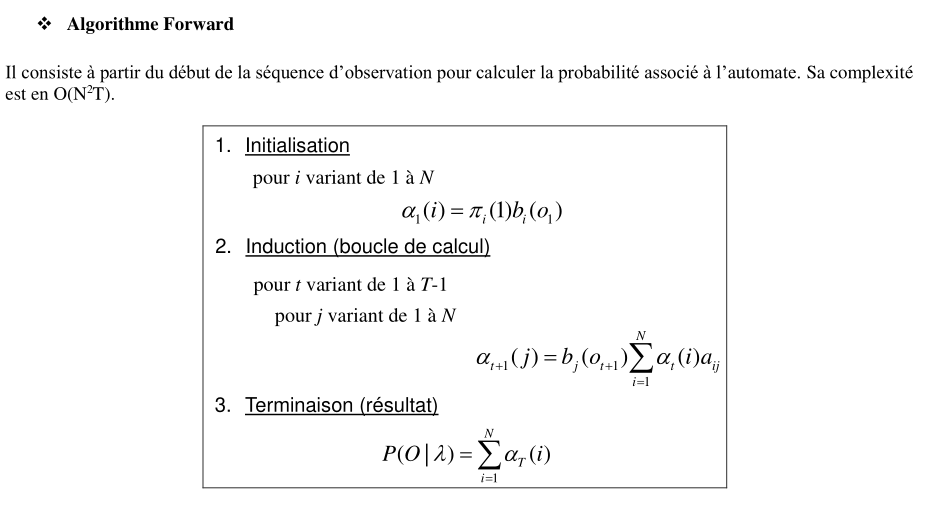

In [52]:
def forward(O, A, B, PI):
    # Taille de la matrice de transition (nombre d'états) = 26
    N = A.shape[0]
    # Longueur de la séquence d'observation
    T = len(O)
    
    # Créer une matrice alpha initialisée avec des zéros
    alpha = np.zeros((T, N), dtype=float)
    
    # Transformer les caractères de la séquence d'observation en indices
    O_indices = [ord(char) - ord('a') for char in O]
    
    # Initialiser la première ligne de alpha avec les probabilités initiales et les probabilités d'émission
    for i in range(N):
        alpha[0, i] = PI[i] * B[i, O_indices[0]]
    
    # Remplir alpha en partant du début vers la fin
    for t in range(1, T):  # Pour chaque temps à partir de 1 jusqu'à T-1
        for j in range(N):  # Pour chaque état actuel
            # Calculer alpha pour l'état j au temps t
            somme = 0
            for i in range(N):  # Pour chaque état précédent
                somme += alpha[t - 1, i] * A[i, j]
            alpha[t, j] = somme * B[j, O_indices[t]]
    
    # Calculer la probabilité totale de la séquence d'observation
    P = 0
    for j in range(N):
        P += alpha[T - 1, j]
    
    return P, alpha


### création de la fonction backward
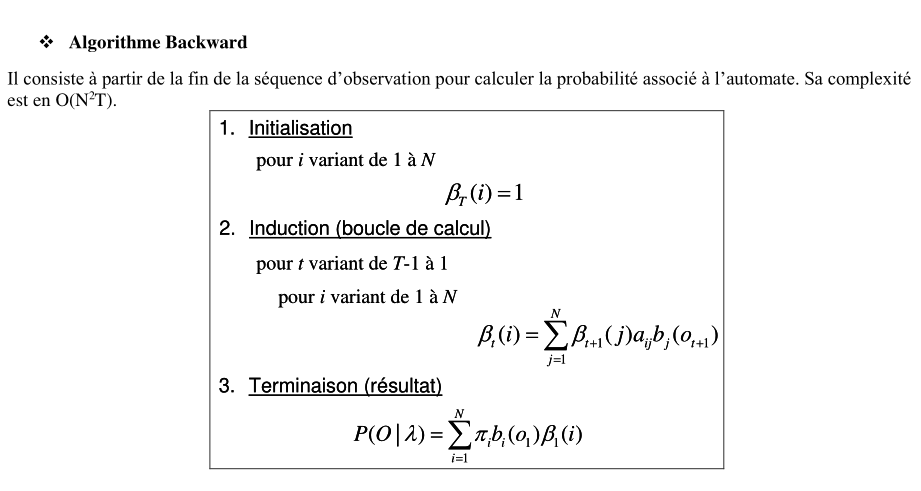

In [53]:
def backward(O, A, B, PI):
    # Taille de la matrice de transition (nombre d'états)
    N = A.shape[0]
    # Longueur de la séquence d'observation
    T = len(O)
    
    # Créer une matrice beta initialisée avec des zéros
    beta = np.zeros((T, N), dtype=float)
    
    # Transformer les caractères de la séquence d'observation en indices
    O_indices = [ord(char) - ord('a') for char in O]
    
    # Initialiser la dernière ligne de beta avec des 1
    beta[T-1, :] = 1
    
    # Remplir beta en partant de la fin vers le début
    for t in range(T - 2, -1, -1):  # On va de T-2 jusqu'à 0
        for i in range(N):  # Pour chaque état
            # Calculer beta pour l'état i au temps t
            somme = 0
            for j in range(N):  # Pour chaque état suivant
                somme += A[i, j] * B[j, O_indices[t + 1]] * beta[t + 1, j]
            beta[t, i] = somme
    
    # Calculer la probabilité totale de la séquence d'observation
    P = 0
    for i in range(N):
        P += PI[i] * B[i, O_indices[0]] * beta[0, i]
    
    return P, beta


### Évaluation du modèle
>_Ici, nous allons tester des mots dans plusieurs langues pour voir si les fonctions implémentées fonctionnent correctement._
>_Ensuite, nous allons créer la matrice de transition et vérifier que les éléments de la diagonale sont les plus grands de leur ligne respective. Si c'est le cas, alors le modèle fonctionne bien._


In [54]:
tab_content = [] #pour stocker les tableaux de resultats
# Test de forward et backward sur les mots "probablement", "probably" et "probabilmente"

mots_test = ["probablement", "probably", "probablimente"]
langues = ["francais","english","italia"]

for mot in mots_test:
    tab = [] #pour stocker les valeurs de probabilités pour chaque mot
    ptfr, alphatfr = forward(mot, AFR, B, lambdas_FR[0])
    pten, alphaten = forward(mot, AEN, B, lambdas_EN[0])
    ptit, alphatit = forward(mot, AIT, B, lambdas_IT[0])
    
    # Calcul de la somme des probabilités
    total_prob = ptfr + pten + ptit
    
    # Normalisation des probabilités
    norm_ptfr = ptfr / total_prob
    tab.append(norm_ptfr)
    norm_pten = pten / total_prob
    tab.append(norm_pten)
    norm_ptit = ptit / total_prob
    tab.append(norm_ptit)
    
    tab_content.append(tab)

### _création de la matrice de confusion_

In [55]:
mat_confusion = np.column_stack((np.array(tab_content[0]), np.array(tab_content[1]), np.array(tab_content[2]))).T
df_mat_confusion = pd.DataFrame(mat_confusion,index=mots_test,columns=langues)
print(df_mat_confusion)

               francais   english    italia
probablement   0.767120  0.051235  0.181645
probably       0.040918  0.950291  0.008792
probablimente  0.411834  0.171340  0.416825


### 2. Comparez les probabilités obtenues pour chaque mot dans les trois langues. Quelle langue a la probabilité la plus élevée pour chaque mot ? Que constatez-vous ?

Réponse :  
>_Après comparaison, on constate que la probabilité de "probablement" en français est plus grande que les autres._

>_La probabilité de "probably" en anglais est plus grande que les autres._

>_La probabilité de "probabilmente" en italien est plus grande que les autres._

>Oui, les résultats sont conformes aux attentes.

### 5. Conclure sur la langue la plus probable pour le mot "probablement", pour le mot "probably" et pour le mot "probabilmente".

> _probablement_ = français, _probably_ = anglais, _probabilmente_ = italien


## Reconnaissance de la langue d’un texte

_Ici, nous allons tester le modèle sur les textes donnés._

### Définition des fonctions qui vont calculer les probabilités d'appartenance à chaque langue des textes

>_Comme la fonction forward ne fonctionne que sur les mots, pour obtenir la probabilité d'un texte dans une langue, nous allons faire la moyenne des probabilités de chaque mot dans cette langue._

>_Nous aurons donc trois fonctions de probabilités._


In [56]:
def matrice_confusion_mots_par_texte(nom_fichier, AFR, AEN, AIT, B, lambdas_FR, lambdas_EN, lambdas_IT):
    mots_text = lire_corpus(nom_fichier)
    mat_confusion_mots = []
    for mot in mots_text:
        pt_fr,alphatfr = forward(mot, AFR, B, lambdas_FR[0])
        pt_en,alphaten = forward(mot, AEN, B, lambdas_EN[0])
        pt_it,alphatit = forward(mot, AIT, B, lambdas_IT[0])
        total_prob = pt_fr + pt_en + pt_it
        mat_confusion_mots.append([pt_fr / total_prob, pt_en / total_prob, pt_it / total_prob])
    #affichons un instant les 10 premiers mot de chaque modèle pour voir si
    print(f"\nLes 10 premiers mots du texte '{nom_fichier}' sont : et leurs probabilité dans chaque langue est :\n")
    mat_confusion_mots = np.array(mat_confusion_mots)
    print(pd.DataFrame(mat_confusion_mots[:10], columns=langues, index=mots_text[:10]))
    return mat_confusion_mots

# Calcul des matrices de confusion pour chaque texte
mat_confusion_texte_1 = matrice_confusion_mots_par_texte("texte_1.txt", AFR, AEN, AIT, B, [np.ones(26) / 26, AFR, B], [np.ones(26) / 26, AEN, B], [np.ones(26) / 26, AIT, B])
mat_confusion_texte_2 = matrice_confusion_mots_par_texte("texte_2.txt", AFR, AEN, AIT, B, [np.ones(26) / 26, AFR, B], [np.ones(26) / 26, AEN, B], [np.ones(26) / 26, AIT, B])
mat_confusion_texte_3 = matrice_confusion_mots_par_texte("texte_3.txt", AFR, AEN, AIT, B, [np.ones(26) / 26, AFR, B], [np.ones(26) / 26, AEN, B], [np.ones(26) / 26, AIT, B])

# Calcul de la moyenne des probabilités et leur normalisation
def moyenne_et_normalisation(mat_confusion):
    #calcul de la moyenne des proba de chaque colonne 
    moyennes = np.mean(mat_confusion, axis=0)
    #normalisation des moyennes
    return moyennes / np.sum(moyennes)


Les 10 premiers mots du texte 'texte_1.txt' sont : et leurs probabilité dans chaque langue est :

              francais   english    italia
les           0.578036  0.187377  0.234587
traitements   0.995312  0.000909  0.003780
statistiques  0.864569  0.011339  0.124092
de            0.470793  0.272428  0.256779
donnees       0.663779  0.156384  0.179837
textuelles    0.654551  0.093604  0.251845
l             0.333333  0.333333  0.333333
lebart        0.185564  0.224818  0.589618
cnrs          0.558030  0.285213  0.156757
enst          0.528764  0.263999  0.207237

Les 10 premiers mots du texte 'texte_2.txt' sont : et leurs probabilité dans chaque langue est :

                francais   english    italia
text            0.323501  0.485784  0.190715
classification  0.106017  0.026662  0.867321
using           0.073074  0.893054  0.033872
machine         0.079227  0.420658  0.500115
learning        0.013951  0.965019  0.021030
techniques      0.884954  0.089830  0.025216
m             

In [57]:
mat_conf = []
# Fonction pour déterminer la langue dominante d'un texte et afficher le résultat
def afficher_langue_dominante(nom_fichier, mat_confusion):
    norm_probfr, norm_proben, norm_probit = moyenne_et_normalisation(mat_confusion)
    mat_conf.append(norm_probfr)
    mat_conf.append(norm_proben)
    mat_conf.append(norm_probit)
    if norm_probfr > max(norm_proben, norm_probit):
        print(f"\n Le texte '{nom_fichier}' est en français, avec une probabilité moyenne de {norm_probfr * 100:.2f} % \n")
    elif norm_proben > max(norm_probfr, norm_probit):
        print(f"\n Le texte '{nom_fichier}' est en anglais, avec une probabilité moyenne de {norm_proben * 100:.2f} % \n")
    elif norm_probit > max(norm_probfr, norm_proben):
        print(f"\n Le texte '{nom_fichier}' est en italien, avec une probabilité moyenne de {norm_probit * 100:.2f} % \n")

# Utilisation de la fonction pour chaque texte
afficher_langue_dominante("texte_1.txt", mat_confusion_texte_1)
afficher_langue_dominante("texte_2.txt", mat_confusion_texte_2)
afficher_langue_dominante("texte_3.txt", mat_confusion_texte_3)



 Le texte 'texte_1.txt' est en français, avec une probabilité moyenne de 52.18 % 


 Le texte 'texte_2.txt' est en anglais, avec une probabilité moyenne de 45.97 % 


 Le texte 'texte_3.txt' est en italien, avec une probabilité moyenne de 50.48 % 



In [58]:
mat_conf = np.row_stack(mat_conf)
mat_conf = mat_conf.reshape(3, 3)
texte = ['texte1','texte2','texte3']
mat_conf = pd.DataFrame(mat_conf, index=texte, columns=langues)
print(mat_conf)

        francais   english    italia
texte1  0.521817  0.210334  0.267849
texte2  0.266050  0.459745  0.274205
texte3  0.279334  0.215912  0.504754


/tmp/ipykernel_156143/3770428165.py:1: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  mat_conf = np.row_stack(mat_conf)


test sur les fichiers

### Discussion sur les mots bien et mal classés

>_Les mots bien classés montrent que le modèle a bien capturé les caractéristiques distinctives de chaque langue. Les erreurs de classification sont souvent dues à des similitudes linguistiques ou à des probabilités d’émission peu distinctives, rendant certaines séquences de lettres difficiles à distinguer entre les langues._


### Influence du nombre de lettres dans un mot

>_Les mots plus longs améliorent la précision du modèle en fournissant davantage de séquences de lettres, ce qui donne un meilleur contexte pour la classification. Les mots courts, sont plus susceptibles d’être mal classés._


### Conclusion sur l'impact de la matrice d’émission

>_La matrice d’émission est cruciale pour la précision de la classification : elle doit être bien ajustée pour chaque langue afin de refléter les caractéristiques spécifiques. Une matrice bien entraînée améliore la différenciation entre les langues, tandis qu'une matrice peu distinctive conduit à davantage d'erreurs._
